This notebook allows you to visualize exploration and exploitation statistics for the Exploration in Malmo Continuous Mountain Cart EMC^2 experiment. make sure your data is in the run_saves/ folder.

In [36]:
import numpy as np
import os
import pylab
import seaborn
import scipy.stats as sp
import pickle
import matplotlib.pyplot as plt
import imageio
from scipy.spatial import distance
import json
from collections import OrderedDict
import os.path as osp
import pandas as pd
DIV_LINE_WIDTH = 50

In [60]:
# Global vars for tracking and labeling data at load time.
exp_idx = 0
units = dict()

# def load_su_data(filepath, filename=''):
#     saves_path = filepath
#     starting_dirs = [0]#[0,100,1000,10000]
#     m_name = 'SAC'
#     nb_runs = 8
#     nb_models = len(starting_dirs)
#     f = "progress.json"
#     #f_time = "runtimes_save.pkl"
#     models_saves = OrderedDict()
#     for dir_nb in range(nb_runs):
#         data = [read_json(saves_path + filename +str(dir_nb+i)+'/' + "progress.json").to_dict('list') for i in range(nb_runs)]
#         models_saves[m_name] = {}
#         models_saves[m_name]['data'] = data

#         for d in data:
#             #print(d)
#             print(len(d['evaluation return']))

def get_datasets(logdir, condition=None):
    """
    Recursively look through logdir for output files produced by
    spinup.logx.Logger. 

    Assumes that any file "progress.txt" is a valid hit. 
    """
    global exp_idx
    global units
    datasets = []
    for root, _, files in os.walk(logdir):
        print(root)
        if 'progress.txt' in files:
            exp_name = None
            try:
                config_path = open(os.path.join(root,'config.json'))
                config = json.load(config_path)
                if 'exp_name' in config:
                    exp_name = config['exp_name']
                    
            except:
                print('No file named config.json')
            condition1 = condition or exp_name or 'exp'
            condition2 = condition1 + '-' + str(exp_idx)
            exp_idx += 1
            if condition1 not in units:
                units[condition1] = 0
            unit = units[condition1]
            units[condition1] += 1

            exp_data = pd.read_table(os.path.join(root,'progress.txt'))
            performance = 'AverageTestEpRet' if 'AverageTestEpRet' in exp_data else 'AverageEpRet'
            exp_data.insert(len(exp_data.columns),'Unit',unit)
            exp_data.insert(len(exp_data.columns),'Condition1',condition1)
            exp_data.insert(len(exp_data.columns),'Condition2',condition2)
            exp_data.insert(len(exp_data.columns),'evaluation return',exp_data[performance])
            data_dict = exp_data.to_dict("list")
            data_dict['total timesteps'] = []
            for e in data_dict['Epoch']:
                data_dict['total timesteps'].append(e * config['steps_per_epoch'])
                
            datasets.append(data_dict)
            print(len(data_dict['total timesteps']))
#         else:
#             print("{}: cannot find progress.txt file, I see: {}".format(root, files))
        
    return datasets      
models_saves = {'SAC':dict()}
models_saves['SAC']['data'] = get_datasets("data/sacsu_cpu_walker100_2l/")

data/sacsu_cpu_walker100_2l/
data/sacsu_cpu_walker100_2l/sacsu_cpu_walker100_2l_s2
34
data/sacsu_cpu_walker100_2l/sacsu_cpu_walker100_2l_s2/simple_save
data/sacsu_cpu_walker100_2l/sacsu_cpu_walker100_2l_s2/simple_save/variables
data/sacsu_cpu_walker100_2l/sacsu_cpu_walker100_2l_s5
34
data/sacsu_cpu_walker100_2l/sacsu_cpu_walker100_2l_s5/simple_save
data/sacsu_cpu_walker100_2l/sacsu_cpu_walker100_2l_s5/simple_save/variables
data/sacsu_cpu_walker100_2l/sacsu_cpu_walker100_2l_s3
34
data/sacsu_cpu_walker100_2l/sacsu_cpu_walker100_2l_s3/simple_save
data/sacsu_cpu_walker100_2l/sacsu_cpu_walker100_2l_s3/simple_save/variables
data/sacsu_cpu_walker100_2l/sacsu_cpu_walker100_2l_s4
34
data/sacsu_cpu_walker100_2l/sacsu_cpu_walker100_2l_s4/simple_save
data/sacsu_cpu_walker100_2l/sacsu_cpu_walker100_2l_s4/simple_save/variables
data/sacsu_cpu_walker100_2l/sacsu_cpu_walker100_2l_s8
34
data/sacsu_cpu_walker100_2l/sacsu_cpu_walker100_2l_s8/simple_save
data/sacsu_cpu_walker100_2l/sacsu_cpu_walker100_2l_s

/home/remy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


In [20]:
nb_epochs = 22
print(len(models_saves['SAC']['data']))
#print([len(models_saves['SAC']['data'][i]['Epoch']) for i  in range(len(models_saves['SAC']['data']))])

6


In [57]:
def plot_with_std(subplot_nb, ax,x,y,err,color,shade_color,label,
                  y_min=None,y_max=None, legend=False, title=None):
    #plt.rcParams.update({'font.size': 15})
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    ax.plot(x,y, color=color, label=label,linewidth=1.5)
    ax.fill_between(x,y-err,y+err,color=shade_color,alpha=0.5)
    if legend:
        leg = ax.legend(loc='bottom right', fontsize=16)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
    ax.set_xlabel('iterations', fontsize=18)
    if subplot_nb == 0:
        ax.set_ylabel('Exploration %', fontsize=18)
    ax.set_xlim(xmin=min(x),xmax=max(x))
    if y_min is not None:
        ax.set_ylim(bottom=y_min,top=y_max)
    if title:
        ax.set_title(title, fontsize=22)

def plot_all_and_median(subplot_nb, ax,x,ys,color,label,
                         y_min=None,y_max=None, legend=False, title=None):
    ax.locator_params(axis='x', nbins=6)
    ax.locator_params(axis='y', nbins=8)
    #plot all
    added_legend = False
    #print(ys)
    median = np.median(np.array(ys), axis=0)
    #print(median)
    for k,y in enumerate(ys):
        if added_legend:
            label = None
        else:
            added_legend = True
        print(max(y))
        ax.plot(x,y, color=color, label=label,linewidth=0.9)
    ax.plot(x,median, color=color, label=label,linewidth=4)
    if legend:
        leg = ax.legend(loc='bottom right', fontsize=16)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
    ax.set_xlabel('steps', fontsize=18)
    if subplot_nb == 0:
        ax.set_ylabel('Evaluation return', fontsize=18)
    #ax.set_xlim(xmin=min(x),xmax=max(x))
    if y_min is not None:
        ax.set_ylim(bottom=y_min,top=y_max)
    if title:
        ax.set_title(title, fontsize=22)
          

243456.28032660484
241273.5476295948
241037.25615763664
241091.42205095288
243261.68582582477
241356.0086786747
240100.0892047882
241248.1544394493
302.11975
313.9995
303.0992
310.46967
312.63367
314.05637
316.17615
307.5876


/home/remy/.local/lib/python3.6/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


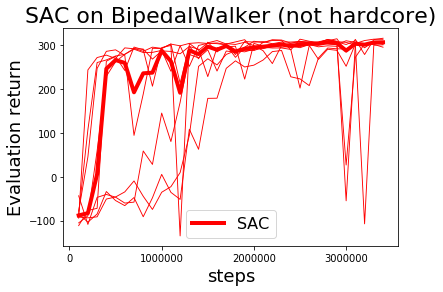

In [61]:
#PLOT ALL MODELS
color = ['red','blue','green','magenta','black','cyan','orange']
f, ax = plt.subplots(1,1,figsize=(6,4))
ax = [ax]
for i,(m_id,d) in enumerate(models_saves.items()):
    runs_data = d['data']
    #print(len(runs_data))
    ys = []
    for run in runs_data:  
        data = run['evaluation return']
        episodes = np.array(run['total timesteps'])
        print(run['Time'][-1])
        if i==1: print(run['time_elapsed'][-1])
        #print(list(run))
        ys.append(data)
    plot_all_and_median(0, ax[0], episodes,ys,color[i],m_id,
                    title="SAC on BipedalWalker (not hardcore)",
                    legend=True)
#plt.savefig("sac_walker_comparison.png", bbox_inches='tight')

In [31]:
#INFOS
for i,(m_id,d) in enumerate(models_saves.items()):
    runs_data = d['data']
    #print(len(runs_data))
    ys = []
    for run in runs_data:  
        data = run['evaluation return']
        episodes = np.array(run['total timesteps'])
        #print(list(run))
        print(data)
        ys.append(data)
    plot_all_and_median(0, ax[0], episodes,ys,color[i],m_id,
                    title="SAC on BipedalWalker (not hardcore)",
                    legend=True)

[-100.08634, -110.669945, -71.10099, -64.27028, -40.773293, -64.88219000000001, -56.174890000000005, -54.48931999999999, -28.97431, -67.42526, -83.517105, -88.33706, -68.6804, -74.63517, -60.31875, -104.13951, -82.74837, -120.67743, -54.281780000000005, -73.228836, -54.855231999999994, -48.50374, -62.322959999999995, -59.605164, -63.125862, -53.62198000000001, -47.74007, -52.761880000000005, -55.945374, -70.90285, -49.934414000000004, -59.547737, -57.552814, -64.70246, -118.928734, -72.58661, -89.40375999999999, -56.36983000000001, -61.994372999999996, -86.737236, -50.257713, -53.151012, -65.47496, -79.98275, -58.791290000000004, -50.385048, -53.76931, -74.435585, -71.81199000000001, -85.20429, -74.97426999999999, -78.39905999999999, -76.00683599999999, -55.630596, -78.98019000000001, -76.8792, -71.91788000000001, -42.221725, -119.21588, -56.404633, -159.9775, -141.72843999999998, -102.92206999999999, -65.830185, -64.028244, -50.01615, -67.96840999999999, -97.9914, -81.35811, -44.96344

ValueError: x and y must have same first dimension, but have shapes (101,) and (100,)

[[6084.3784, 7454.071999999999, 9357.597, 9768.41, 10696.021, 10270.033000000001, 11009.159, 11101.483, 11490.21, 11227.443000000001], [6469.203, 8111.7393, 9588.257, 10100.985999999999, 10536.798999999999, 10895.763, 11106.329, 11300.635, 11470.889, 11718.011999999999], [5444.236, 7941.9087, 8463.098, 9785.385, 9880.653, 10314.502, 11109.388, 10892.59, 11277.153999999999, 11152.608], [5949.7734, 7702.3047, 9283.928, 9483.207, 10241.1455, 10343.105, 10979.556999999999, 11170.098999999998, 11051.58, 11634.983999999999], [5967.4463, 8079.1455, 8311.947, 9247.083, 9582.98, 10242.981, 10112.266, 9245.283000000001, 10801.8545, 10400.6], [5382.9834, 6599.5947, 8518.043, 9419.263, 9822.447, 9822.81, 10798.646, 11003.545, 11310.62, 10598.537], [6973.081, 7779.749, 8985.609, 9573.729, 9847.224, 10081.791, 10278.811, 10192.368, 11037.01, 11331.788999999999], [6800.802, 8896.396, 9878.331, 10409.59, 11018.8, 11735.03, 11863.114, 12055.928, 11384.542, 12380.173]]
11490.21
11718.011999999999
11277.

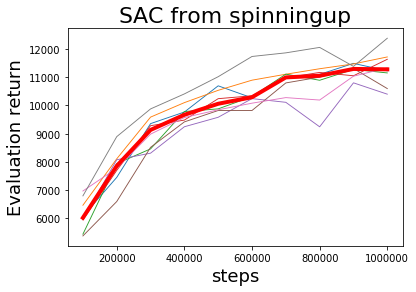

In [53]:
# SINGLE PLOT


#PLOT ALL + MEDIAN
ys = []


for run in models_saves['SAC spinup']['data']:
    
    data = run['evaluation return']
    episodes = np.array(run['total timesteps'])
    #print(episodes)
    ys.append(data)
title = ''
#y_min=-100, y_max=330
print(ys)

plot_all_and_median(0, ax[0], episodes,ys,None,'SAC',
                    title='SAC from spinningup',
                    legend=False)
plt.savefig("tmp_immm.png", bbox_inches='tight')

In [ ]:
# Compact Visu
def one_explo_maps(max_episodes=nb_episodes, run_nb=0, model_name='emmc3d_amb'):
    f, ax = plt.subplots(1,1,figsize=(5,5))
    b_k = saves[model_name][run_nb]
    print(b_k['parameters']['model_type'])
    plot_agent_pos_exploration(ax, b_k['end_agent_x'][:max_episodes],
                                b_k['end_agent_z'][:max_episodes],
                                b_k['end_cart_x'][:max_episodes], False)
    ax.plot(b_k['end_pickaxe_x'][:max_episodes],b_k['end_pickaxe_z'][:max_episodes],'g.',markersize=5)
    ax.plot(b_k['end_shovel_x'][:max_episodes],b_k['end_shovel_z'][:max_episodes],'b.',markersize=5)
    plt.tight_layout(pad=-1.0)
    
for i in range(nb_runs):
    one_explo_maps(max_episodes=40000, run_nb=i)
    plt.savefig("graphics/amb_exploration_map", bbox_inches='tight')
    plt.show()

In [ ]:
# Compact Visu
def compact_explo_maps(max_episodes=None, run_nb=0):
    f, (ax0, ax1, ax2, ax3) = plt.subplots(1,4,figsize=(20,5))
    ax = (ax0, ax1, ax2, ax3)
    for i, (m_name, m_id) in enumerate(zip(model_full_names,model_filenames)):
        b_k = saves[m_id][run_nb]
        print(b_k['parameters']['model_type'])
        #print(m_id)
        #print(i)
        #for i in range(nb_runs):
        #b_k = saves[m_id][i]
        #print(b_k['end_agent_x'][:10])
        if max_episodes is None:
            plot_agent_pos_exploration(ax[i], b_k['end_agent_x'],
                                        b_k['end_agent_z'],
                                        b_k['end_cart_x'], titles[i])
            ax[i].plot(b_k['end_pickaxe_x'],b_k['end_pickaxe_z'],'g.',markersize=20)
            ax[i].plot(b_k['end_shovel_x'],b_k['end_shovel_z'],'b.',markersize=2)
        else:
            plot_agent_pos_exploration(ax[i], b_k['end_agent_x'][:max_episodes],
                                        b_k['end_agent_z'][:max_episodes],
                                        b_k['end_cart_x'][:max_episodes], titles[i])
            ax[i].plot(b_k['end_pickaxe_x'][:max_episodes],b_k['end_pickaxe_z'][:max_episodes],'g.',markersize=5)
            ax[i].plot(b_k['end_shovel_x'][:max_episodes],b_k['end_shovel_z'][:max_episodes],'b.',markersize=5)
            print(len(b_k['end_shovel_x'][:max_episodes]))
    #add pickaxe and shovel positions
        print(len(np.unique(b_k['end_cart_x'])))
    plt.tight_layout(pad=-1.0)

for i in range(nb_runs):
    compact_explo_maps(max_episodes=40000, run_nb=i)
    #plt.savefig("aa_newold_final2", bbox_inches='tight')
    #plt.show()

In [ ]:
# # GIF out of compact vizu
# step_size = 1000
# nb_steps = int(nb_episodes / step_size)
# filenames = []
# for i,max_episodes in enumerate(np.arange(step_size,nb_episodes+step_size,step_size)):
#     print(i)
#     compact_explo_maps(max_episodes)
#     f_name = "graphics/exploration_coverage_{}.png".format(i)
#     plt.savefig(f_name, bbox_inches='tight')
#     filenames.append(f_name)

# import imageio
# images = []
# for filename in filenames:
#     images.append(imageio.imread(filename))
# imageio.mimsave('graphics/exploration.gif', images, duration=0.3)

# GIF out of compact vizu
def explo_gif(run_nb=0):
    print("Making an exploration GIF for run nb {}".format(run_nb))
    step_size = 1000
    nb_steps = int(30000 / step_size)
    filenames = []
    for i,max_episodes in enumerate(np.arange(step_size,nb_episodes+step_size,step_size)):
        #print(i)
        compact_explo_maps(max_episodes,run_nb)
        f_name = "graphics/exploration_coverage_{}.png".format(i)
        plt.savefig(f_name, bbox_inches='tight')
        filenames.append(f_name)
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('graphics/exploration{}.gif'.format(run_nb), images, duration=0.3)
for i in range(nb_runs):
    explo_gif(i)


![](graphics/exploration0.gif)
![](graphics/exploration1.gif)


In [ ]:
def get_nb_cells(x,y,nb_bins,rng):
    if y is not None: #2D case
        bin_numbers = sp.binned_statistic_2d(x, y, None, 'count',
                                                bins=nb_bins, range=rng).binnumber
    else: #1D case
        bin_numbers = sp.binned_statistic(x, None, 'count',
                                             bins=nb_bins, range=rng).binnumber
    return len(np.unique(bin_numbers))

# get env specific bounds
b = config.get_env_bounds('emmc_env')
nb_2d_cells = [10,30]
total_2d_cells = nb_2d_cells[0] * nb_2d_cells[1]
nb_c_cells = 200
nb_b_cells = 2**5

# Grid cell visualization
for m_id in model_filenames:
    stat[m_id]['agent_cells'] = []
    stat[m_id]['pickaxe_cells'] = []
    stat[m_id]['shovel_cells'] = []
    stat[m_id]['cart_cells'] = []
    stat[m_id]['nb_cart_touched'] = []
    stat[m_id]['b_combinations'] = []
    stat[m_id]['first_blocks'] = []
    stat[m_id]['first_swing_left'] = []
    stat[m_id]['first_swing_right'] = []
    stat[m_id]['first_cart_touched'] = []
    stat[m_id]['eval_cart_touched'] = []
    stat[m_id]['chosen_modules'] = []
def mean_std(data_name):
    mean = round(np.mean(stat[m_id][data_name]),3)
    std = round(np.std(stat[m_id][data_name]),3)
    return mean,std

name_2d_spaces = ['agent', 'pickaxe', 'shovel']
for m_name, m_id in zip(model_full_names,model_filenames):
    for i in range(nb_runs):
        b_k = saves[m_id][i]
        
        # grid cell for 2d outcome spaces (agent, pickaxe, shovel)
        for outc_space in name_2d_spaces:
            #print(outc_space+'_x')
            name = 'end_{}'.format(outc_space)
            bnd_x = b.get_bounds([outc_space+'_x'])
            bnd_z = b.get_bounds([outc_space+'_z'])
            bnds = bnd_x + bnd_z
            #print(bnds)
            nb_expl_cells = get_nb_cells(b_k[name+'_x'], b_k[name+'_z'],
                                         nb_2d_cells, bnds)
            stat[m_id][outc_space+'_cells'].append((nb_expl_cells/total_2d_cells)*100)
        
        #cart grid cell
        c_Xs = b_k['end_cart_x']
        nb_expl_cells = get_nb_cells(c_Xs, None,
                                     nb_c_cells, b.get_bounds(['cart_x']))
        stat[m_id]['cart_cells'].append((nb_expl_cells/nb_c_cells)*100)
        stat[m_id]['nb_cart_touched'].append(len(np.unique(b_k['end_cart_x'])))
        
        # first swing or touched car info
        try:
            first_cart_touched = next(x[0] for x in enumerate(c_Xs) if x[1] != 291.5)
        except StopIteration:
            first_cart_touched = 'never'
        # check for cart swing up
        try:
            first_swing_left = next(x[0] for x in enumerate(c_Xs) if x[1] > 296.2)
        except StopIteration:
            first_swing_left = 'never'
        try:
            first_swing_right = next(x[0] for x in enumerate(c_Xs) if x[1] < 286.8)
        except StopIteration:
            first_swing_right = 'never'
        
        #blocks
        b_vec = [b_k['end_block_0'], b_k['end_block_1'], b_k['end_block_2'],
                 b_k['end_block_3'], b_k['end_block_4']]
        b_vec = np.array(b_vec).reshape(-1,5)
        stat[m_id]['b_combinations'].append(len(np.unique(b_vec, axis=0)))
        
    
        
#         #blocks cell
#         first_blocks_found = []
#         for i in range(3):
#             try:
#                 first_found = nb_blocks.index(i)
#             except ValueError:
#                 first_found = 'never'
#             nb_found = nb_breads.count(float(i))
#             first_breads_found.append([first_found,nb_found])
#         #print( first_breads_found

#         final_bread_vec = np.zeros((len(bread_vec[0]),5))
#         #reconstruct original bread vectors
#         for bread_idx, v in enumerate(bread_vec):
#             for iter_idx in range(len(v)):
#                 final_bread_vec[iter_idx,bread_idx] = v[iter_idx]

#         b_explored_bins = len(np.unique(final_bread_vec,axis=0))
        
        

        
#         a_explored_bins, c_explored_bins, b_explored_bins, first_swing_left, first_swing_right, first_breads_found,\
#         first_cart_touched = get_grid_cell_exploration(b_k['end_agent_x'],
#                               b_k['end_agent_z'],
#                               b_k['end_cart_x'],
#                               b_k['end_bread_recovered'],
#                               [b_k['block_0'],b_k['block_1'],b_k['block_2']],
#                               c_bins=nb_c_cells,a_bins_x=nb_a_cells_x, a_bins_z=nb_a_cells_z, info=False)
#         stat[m_id]['agent_cells'].append((a_explored_bins/nb_a_cells)*100)
#         stat[m_id]['cart_cells'].append((c_explored_bins/nb_c_cells)*100)
#         stat[m_id]['b_combinations'].append((b_explored_bins/nb_b_cells)*100)
#         stat[m_id]['first_breads'].append(first_breads_found) 
        stat[m_id]['first_swing_left'].append(first_swing_left) 
        stat[m_id]['first_swing_right'].append(first_swing_right)
        stat[m_id]['first_cart_touched'].append(first_cart_touched)
        
print('--- EXPLORATION ---')
exploration_metrics = ['agent_cells', 'cart_cells', 'b_combinations',
                       'first_cart_touched', 'nb_cart_touched', 'first_swing_left', 'first_swing_right']

for m_name, m_id in zip(model_full_names,model_filenames):
    print("### " + m_name + " ####")
    
    for i in range(nb_runs):
        
        b_k = saves[m_id][i]
        a = np.array(b_k['choosen_modules'])
        unique, counts = np.unique(a, return_counts=True)
        #print dict(zip(unique, counts))
    
    for metric in exploration_metrics:
        values = stat[m_id][metric]
        if not 'first' in metric:
            mean,std = mean_std(metric)
            values = [round(v,1) for v in values]
            print(metric + ':' + '%s, MEAN: %s, STD: %s' % (values, mean, std))
        else:
            print(metric + ':' + '%s' % (values))

#     for i in range(6):
#         first_found = []
#         nb_found = []
#         for j in range(nb_runs):
#             first_found.append(stat[m_id]['first_breads'][j][i][0])
#             nb_found.append(stat[m_id]['first_breads'][j][i][1])
#         print('bread %s:' % i)
#         print("first found: %s" % first_found)
#         print("nb_found: %s" % nb_found)   


In [ ]:
# Grid cell exploration curves
step_size = 1000
nb_steps = int(nb_episodes / step_size)
print('ploting using {} steps'.format(nb_steps))
all_a_explo = np.zeros((nb_models,nb_runs,nb_steps+1))
all_p_explo = np.zeros((nb_models,nb_runs,nb_steps+1))
all_s_explo = np.zeros((nb_models,nb_runs,nb_steps+1))
all_c_explo = np.zeros((nb_models,nb_runs,nb_steps+1))
all_b_explo = np.zeros((nb_models,nb_runs,nb_steps+1))
name_2d_spaces = ['agent', 'pickaxe', 'shovel']
for m_nb,(m_name, m_id) in enumerate(zip(model_full_names,model_filenames)):
    print(m_name)
    for i in range(nb_runs):
        b_k = saves[m_id][i]
        a_explo = [0.]
        p_explo = [0.]
        s_explo = [0.]
        c_explo = [0.]
        b_explo = [0.]
        for max_episodes in np.arange(step_size,nb_episodes+step_size,step_size):
            
            for outc_space in name_2d_spaces:
                #print(outc_space+'_x')
                name = 'end_{}'.format(outc_space)
                bnd_x = b.get_bounds([outc_space+'_x'])
                bnd_z = b.get_bounds([outc_space+'_z'])
                bnds = bnd_x + bnd_z
                Xs = b_k[name+'_x'][:max_episodes]
                Zs = b_k[name+'_z'][:max_episodes]
                expl_cells = get_nb_cells(Xs, Zs, nb_2d_cells, bnds)
                if outc_space == 'agent':
                    a_expl_cells = expl_cells
                elif outc_space == 'pickaxe':
                    p_expl_cells = expl_cells
                elif outc_space == 'shovel':
                    s_expl_cells = expl_cells
        
            #cart grid cell
            c_Xs = b_k['end_cart_x'][:max_episodes]
            c_expl_cells = get_nb_cells(c_Xs, None,
                                         nb_c_cells, b.get_bounds(['cart_x']))
            
            
            a_explo.append((a_expl_cells/total_2d_cells)*100)
            s_explo.append((s_expl_cells/total_2d_cells)*100)
            p_explo.append((p_expl_cells/total_2d_cells)*100)
            
            c_explo.append((c_expl_cells/nb_c_cells)*100)
            
            #blocks
            b_vec = [b_k['end_block_0'][:max_episodes],
                     b_k['end_block_1'][:max_episodes],
                     b_k['end_block_2'][:max_episodes],
                     b_k['end_block_3'][:max_episodes],
                     b_k['end_block_4'][:max_episodes]]
            b_vec = np.array(b_vec).reshape(-1,5)
            b_explored_combs = len(np.unique(b_vec, axis=0))
            b_explo.append((b_explored_combs/nb_b_cells)*100)
        all_a_explo[m_nb,i,:] = a_explo
        all_p_explo[m_nb,i,:] = p_explo
        all_s_explo[m_nb,i,:] = s_explo
        all_c_explo[m_nb,i,:] = c_explo
        all_b_explo[m_nb,i,:] = b_explo
        
#print np.sum(all_a_explo,axis=1).shape
#print np.mean(np.sum(all_a_explo,axis=1),axis=0).shape
#break
colors = ['red','blue','green','magenta','black','cyan','orange']
mean_a_explo = np.mean(all_a_explo,axis=1)
mean_p_explo = np.mean(all_p_explo,axis=1)
mean_s_explo = np.mean(all_s_explo,axis=1)
mean_b_explo = np.mean(all_b_explo,axis=1)
mean_c_explo = np.mean(all_c_explo,axis=1)

std_a_explo = np.std(all_a_explo,axis=1)
std_p_explo = np.std(all_p_explo,axis=1)
std_s_explo = np.std(all_s_explo,axis=1)
std_b_explo = np.std(all_b_explo,axis=1)
std_c_explo = np.std(all_c_explo,axis=1)

In [ ]:
def plot_with_std(subplot_nb, ax,x,y,err,color,shade_color,label,
                  y_min=None,y_max=None, legend=False, title=None):
    #plt.rcParams.update({'font.size': 15})
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    ax.plot(x,y, color=color, label=label,linewidth=1.5)
    ax.fill_between(x,y-err,y+err,color=shade_color,alpha=0.5)
    if legend:
        leg = ax.legend(loc='bottom right', fontsize=16)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
    ax.set_xlabel('iterations', fontsize=18)
    if subplot_nb == 0:
        ax.set_ylabel('Exploration %', fontsize=18)
    ax.set_xlim(xmin=min(x),xmax=max(x))
    if y_min is not None:
        ax.set_ylim(bottom=y_min,top=y_max)
    if title:
        ax.set_title(title, fontsize=22)

def plot_all_and_median(subplot_nb, ax,x,ys,color,shade_color,label,
                         y_min=None,y_max=None, legend=False, title=None):
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    #plot all
    added_legend = False
#     ys = [y.tolist() for y in ys]
#     ys.sort(key=lambda x: x[-1])
#     for k,y in enumerate(ys):
#         if added_legend:
#             label = None
#         else:
#             added_legend = True
#         if k == int(nb_runs/2):
#             linewidth = 4
#         else:
#             linewidth = 0.3
#         ax.plot(x,y, color=color, label=label,linewidth=linewidth)
    median = np.median(ys,axis=0)
    for k,y in enumerate(ys):
        if added_legend:
            label = None
        else:
            added_legend = True
        ax.plot(x,y, color=color, label=label,linewidth=0.3)
    ax.plot(x,median, color=color, label=label,linewidth=4)
    if legend:
        leg = ax.legend(loc='bottom right', fontsize=16)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
    ax.set_xlabel('iterations', fontsize=18)
    if subplot_nb == 0:
        ax.set_ylabel('Exploration %', fontsize=18)
    ax.set_xlim(xmin=min(x),xmax=max(x))
    if y_min is not None:
        ax.set_ylim(bottom=y_min,top=y_max)
    if title:
        ax.set_title(title, fontsize=22)
        

In [ ]:
metrics_mean_explo = [mean_a_explo, mean_p_explo, mean_s_explo, mean_b_explo, mean_c_explo] 
metrics_std_explo = [std_a_explo, std_p_explo, std_s_explo, std_b_explo, std_c_explo]
plot_steps = np.arange(0,nb_episodes+step_size,step_size)
colors = ['red','blue','green','magenta','black','cyan','orange']
shades_colors = ['lightsalmon','skyblue','lightgreen','violet']
title_info = ["agent", "pickaxe", "shovel", "blocks", "cart"]
model_names = titles
metric = ["agent","pickaxe","shovel","blocks","cart"]
maxes=[85,85,85,100,85]

# # Averaged plots
# f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5,figsize=(20,4))
# ax = (ax0, ax1, ax2, ax3, ax4)
# print(model_filenames)
# for j, (models_mean_explo, models_std_explo) in enumerate(zip(metrics_mean_explo, metrics_std_explo)):
#     for i,(mean_explo, std_explo) in enumerate(zip(models_mean_explo, models_std_explo)):
#         y = mean_explo
#         err = std_explo
#         title = ''
#         plot_with_std(j, ax[j], plot_steps,y,err,colors[i],shades_colors[i],model_names[i],
#                       y_min=0,y_max=maxes[j], title=title+title_info[j], legend=True)
        
# #plt.savefig("graphics/grid_cell_exploration_mmc.pdf", bbox_inches='tight')
# #plt.savefig("grid_cell_exploration_samebt.png", bbox_inches='tight')
# plt.show()

#PLOT ALL + MEDIAN
all_explo = [all_a_explo, all_p_explo, all_s_explo, all_b_explo, all_c_explo]
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5,figsize=(20,4))
ax = (ax0, ax1, ax2, ax3, ax4)
print(model_filenames)
for j, models_all_explo in enumerate(all_explo):
    for i, explo in enumerate(models_all_explo):
        ys = explo
        title = ''
        plot_all_and_median(j, ax[j], plot_steps,ys,colors[i],shades_colors[i],model_names[i],
                      y_min=0,y_max=maxes[j], title=title+title_info[j], legend=True)
plt.savefig("graphics/grid_cell_exploration_mmc.png", bbox_inches='tight')


In [ ]:
def plot_with_std(x,y,err,color,shade_color,label,y_min,y_max):
    plt.plot(x,y, color=color, label=label,linewidth=1.5)
    plt.fill_between(x,y-err,y+err,color=shade_color,alpha=0.5)
    leg = plt.legend(loc='lower right')
    for legobj in leg.legendHandles:
        legobj.set_linewidth(4.0)
    plt.xlabel('episodes')
    plt.ylabel('exploration %')
    if y_min is not None:
        plt.ylim(ymin=y_min,ymax=y_max)
    

labels = ['RND','F-RGB','RMB','AMB']
shades_colors = ['lightsalmon','skyblue','lightgreen','violet']
print("agent exploration")
x = np.arange(0,nb_episodes+step_size,step_size)
for i in range(nb_models):
    print(std_a_explo[i,-1])
    y = mean_a_explo[i,:]
    err = std_a_explo[i,:]
    plot_with_std(x,y,err,colors[i],shades_colors[i],labels[i],0,100)
#plt.savefig("dist_agent_pos_expl.pdf", bbox_inches='tight')
plt.show()

print("shovel exploration")
x = np.arange(0,nb_episodes+step_size,step_size)
for i in range(nb_models):
    print(std_s_explo[i,-1])
    y = mean_s_explo[i,:]
    err = std_s_explo[i,:]
    plot_with_std(x,y,err,colors[i],shades_colors[i],labels[i],0,100)
#plt.savefig("dist_agent_pos_expl.pdf", bbox_inches='tight')
plt.show()

print("pickaxe exploration")
x = np.arange(0,nb_episodes+step_size,step_size)
for i in range(nb_models):
    print(std_p_explo[i,-1])
    y = mean_p_explo[i,:]
    err = std_p_explo[i,:]
    plot_with_std(x,y,err,colors[i],shades_colors[i],labels[i],0,100)
#plt.savefig("dist_agent_pos_expl.pdf", bbox_inches='tight')
plt.show()

print("cart")
for i in range(nb_models):
    print(std_c_explo[i,-1])
    y = mean_c_explo[i,:]
    err = std_c_explo[i,:]
    plot_with_std(x,y,err,colors[i],shades_colors[i],labels[i],0,100)
#plt.savefig("dist_cart_pos_expl.pdf", bbox_inches='tight')
plt.show()

print("blocks")
for i in range(nb_models):
    y = mean_b_explo[i,:]
    err = std_b_explo[i,:]
    plot_with_std(x,y,err,colors[i],shades_colors[i],labels[i],0,100)
#plt.savefig("dist_bread_pos_expl.pdf", bbox_inches='tight')
plt.show()
#plt.plot(mean_a_explo, color='red', label=m_name.replace('_',' '))
#plt.plot(mean_c_explo, color='blue', label=m_name.replace('_',' '))
#plt.plot(mean_b_explo, color='green', label=m_name.replace('_',' '))
        

In [ ]:
def plot_interests(ax,subplot_nb,interest_dict, legend=True, labels=None):
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    colors = ['red','blue','green','magenta','black',
              'cyan','orange','powderblue','salmon','aqua','darkolivegreen',
             'orchid','indigo','saddlebrown']
    for i,(name,interests) in enumerate(sorted(interest_dict.items())):
        #print(name)
        if labels is not None:
            ax.plot(interests, color=colors[i], label=labels[i],linewidth=1.5)
        else:
            ax.plot(interests, color=colors[i], label=name.replace('_',' '),linewidth=1.5)
    if subplot_nb == 0:
        ax.set_ylabel('Interest', fontsize=18)
        
    ax.set_xlabel('Iterations', fontsize=18)
    if legend:
        leg = ax.legend(loc='upper left')
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)

short_labels = ['agent','bread','cart','distr 1','distr 2','distr 3', 'distr 4']

# Plot interest curves:

for i in range(9):
    f, (ax0, ax1) = plt.subplots(1,2,figsize=(16,4))
    ax = (ax0, ax1)
    ints = saves[model_filenames[2]][i]['interests']
    plot_interests(ax[0],0,ints,legend=True,labels=None)
#plt.savefig("aaa_newold_interests_samebt.png", bbox_inches='tight')




In [ ]:
# PLOT 3 SAMPLES OF AMB INTERESTS
f, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(24,4))
ax = (ax0, ax1, ax2)
for i,run_nb in enumerate([0,3,8]):
    ints = saves[model_filenames[2]][run_nb]['interests']
    plot_interests(ax[i],i,ints,legend=True,labels=None)
plt.savefig("graphics/interest_curves_amb_mmc.png", bbox_inches='tight')


In [ ]:
# Plot competence evolution for amb runs
f, (ax0, ax1) = plt.subplots(1,2,figsize=(20,4))
ax = (ax0, ax1)
m_names = ['pickaxe_end_pos']

for i in range(1):
    dists = {}
    for m_name in m_names:
        
        all_goals = saves[model_filenames[2]][1]['modules'][m_name].generated_goals
        all_outs = saves[model_filenames[2]][1]['modules'][m_name].observed_outcomes
        print(len(all_goals))
        print(len(all_outs))
        goals = np.array([all_goals[k-1] for k in range(5,len(all_goals),5)])
        outs = np.array([all_outs[k-1] for k in range(5,len(all_outs),5)])
        print(goals[-5:])
        print(outs[-5:])
        d = np.linalg.norm(goals - outs,axis=1)
        dists[m_name] = d
    #euc_d2 = np.linalg.norm(goals - outs,axis=1)
#     print(goals[0:3])
#     print(outs[0:3])
#     print(dists[0:3])
#     print(euc_d[0:3])
#     print(euc_d2[0:3])
#     print("h")
    plot_interests(ax[i],i,dists,legend=False,labels=None)

In [ ]:
# get interest curves names:
labels_2 = [s.replace('_',' ') for s in np.unique(saves[model_filenames[3]][0]['choosen_modules'])]

#labels = ['agent final position','bread final count','cart final position',
#               'fixed distractor 1 final position','fixed distractor 2 final position','moving distractor 1 final position', 'moving distractor 2 final position']
colors = ['red','blue','green','magenta','black','cyan','orange']

fig = pylab.figure()
figlegend = pylab.figure(figsize=(3.5,2))
ax = fig.add_subplot(111)
line_data = []
#for i in range(len(labels)):
#    line_data.append([range(10), pylab.randn(10), colors[i]])
print(len(labels_2))
if len(labels_2) == 3:
    lines = ax.plot(range(10),pylab.randn(10),colors[0],
                    range(10),pylab.randn(10),colors[1],
                    range(10),pylab.randn(10),colors[2])
elif len(labels_2) == 5:
    lines = ax.plot(range(10),pylab.randn(10),colors[0],
                    range(10),pylab.randn(10),colors[1],
                    range(10),pylab.randn(10),colors[2],
                    range(10),pylab.randn(10),colors[3],
                    range(10),pylab.randn(10),colors[4])
    
leg = figlegend.legend(lines, labels_2[:len(labels_2)], 'center')
for legobj in leg.legendHandles:
            legobj.set_linewidth(6.0)
        
figlegend.show()
figlegend.savefig('legend.png')

In [ ]:
# Time complexity analysis
for m_name, m_id in zip(model_full_names,model_filenames):
    print(m_id)
    b_k = saves[m_id][4]
    if 'runtimes' in b_k:
        rts = b_k['runtimes']
        #print(rts['produce'][-100:])
        plt.plot(rts['produce'],label='choose policy')
        plt.plot(rts['run'],label='run episode')
        plt.plot(rts['perceive'],label='add to memory')
        plt.legend()
        plt.ylabel('seconds')
        plt.xlabel('episodes')
    plt.savefig("time_complexity.png")
    plt.show()


In [ ]:
# PLOT percentage of modules that moved specific objects
def plot_explo_per_module(ax, b_k, obj_labels, initial_pos, nb_steps, spaces=False, legend=False, title=None):
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    #first get list of idx where object moved for each module
    outcomes = []
    nb_outs = len(b_k[obj_labels[0]])
    nb_bt = nb_outs - len(b_k['choosen_modules'])
    #print(nb_bt)
    #print("adding {} bootstrap to module list".format(nb_bt))
    modules = ["random"]*nb_bt + b_k['choosen_modules']
    for i in range(len(b_k[obj_labels[0]])):
        outcomes.append([b_k[obj][i] for obj in obj_labels])
    #print(len(modules))
    #print(outcomes[100:150])
    #return
    
    
    dict_module_idx = {}
    for m_name in np.unique(modules):
        #first list -> when the module was choosen
        #second list -> when the module moved the object
        dict_module_idx[m_name] = [np.zeros(nb_outs), np.zeros(nb_outs)]
    for i, (outc, module_name) in enumerate(zip(outcomes, modules)):
        dict_module_idx[module_name][0][i] = 1
        if outc != initial_pos:
            dict_module_idx[module_name][1][i] = 1
    
    # now plot
    for m_name, info in dict_module_idx.items():
        #print(m_name)
        used = info[0]
        counts = info[1]
        d = []
        x = []
        for max_episodes in np.arange(step_size,nb_episodes+step_size,step_size):
            d.append(np.sum(counts[max_episodes-step_size:max_episodes]) / np.sum(used[max_episodes-step_size:max_episodes]))
            x.append(max_episodes)
        if spaces and m_name in spaces:
            if legend:
                label = m_name
            else:
                label = None
            ax.plot(x,d, label=label,linewidth=1.5, color=colors[spaces.index(m_name)])
    if legend: 
        ax.legend(fontsize=18)
    ax.set_xlabel('Iterations', fontsize=18)
    ax.set_ylabel('Prob. to move object', fontsize=18)
    if title:
        ax.set_title(title, fontsize=22)
        
    
   

In [ ]:
step_size = 2000
nb_steps = int(nb_episodes / step_size)
print('PICKAXE')        
for m_nb,(m_name, m_id) in enumerate(zip(model_full_names,model_filenames)):
    if m_nb != 1:
        continue
    for i in range(nb_runs):
        print(i)
        f, ax = plt.subplots(1,1,figsize=(8,4))
        print(m_name)
        b_k = saves[m_id][i]
        plot_explo_per_module(ax, b_k, ['end_pickaxe_x', 'end_pickaxe_z'], [292.5, 436.5], nb_steps)
        plt.legend()
        #plt.savefig("oldnew_explo_mods_pickaxe{}{}.png".format(m_name,i), bbox_inches='tight')
        plt.show()
# print('SHOVEL')        
# for m_nb,(m_name, m_id) in enumerate(zip(model_full_names,model_filenames)):
#     if m_nb == -1:
#         continue
#     for i in range(nb_runs):
#         print(i)
#         f, ax = plt.subplots(1,1,figsize=(8,4))
#         print(m_name)
#         b_k = saves[m_id][i]
#         plot_explo_per_module(ax, b_k, ['end_shovel_x', 'end_shovel_z'], [290.5, 436.5], nb_steps)
#         plt.legend()
#         plt.savefig("oldnew_explo_mods_shovel{}{}.png".format(m_name,i), bbox_inches='tight')
#         plt.show()

# print('BLOCKS')
# for m_nb,(m_name, m_id) in enumerate(zip(model_full_names,model_filenames)):
#     if m_nb == -1:
#         continue
#     for i in range(nb_runs):
#         print(i)
#         f, ax = plt.subplots(1,1,figsize=(8,4))
#         print(m_name)
#         b_k = saves[m_id][i]
#         initial_v = [-1.0, -1.0, -1.0, -1.0, -1.0]
#         labels = ['end_block_0','end_block_1','end_block_2', 'end_block_3','end_block_4']
#         plot_explo_per_module(ax, b_k, labels, initial_v, nb_steps)
#         plt.legend()
#         plt.savefig("oldnew_explo_mods_blocks{}{}.png".format(m_name,i), bbox_inches='tight')
#         plt.show()
        

print('CART')
for m_nb,(m_name, m_id) in enumerate(zip(model_full_names,model_filenames)):
    if m_nb != 1:
        continue
    for i in range(nb_runs):
        print(i)
        f, ax = plt.subplots(1,1,figsize=(8,4))
        print(m_name)
        b_k = saves[m_id][i]
        initial_v = [291.5]
        labels = ['end_cart_x']
        #plt.savefig("newnew_explo_mods_cart{}{}.png".format(m_name,i), bbox_inches='tight')
        plot_explo_per_module(ax, b_k, labels, initial_v, nb_steps)
        plt.legend()
        plt.show()

In [ ]:
# ALL IN ONE PLOT
step_size = 2000
nb_steps = int(nb_episodes / step_size)
f, (ax0, ax1) = plt.subplots(1,2,figsize=(14,4))
ax = (ax0, ax1)
print('PICKAXE')       
spaces = ['agent', 'pickaxe', 'blocks', 'cart' ,'random']
for m_nb,(m_name, m_id) in enumerate(zip(model_full_names,model_filenames)):
    if m_nb != 1:
        continue
    for i in range(nb_runs):
        #print(i)
        #print(m_name)
        b_k = saves[m_id][i]
        plot_explo_per_module(ax[0], b_k, ['end_pickaxe_x', 'end_pickaxe_z'],
                              [292.5, 436.5], nb_steps, spaces=spaces, title='Pickaxe')

print('CART')
for m_nb,(m_name, m_id) in enumerate(zip(model_full_names,model_filenames)):
    if m_nb != 1:
        continue
    for i in range(nb_runs):
        #print(i)
        #print(m_name)
        b_k = saves[m_id][i]
        initial_v = [291.5]
        labels = ['end_cart_x']
        if i == nb_runs - 1:
            legend = True
        else:
            legend = False
        plot_explo_per_module(ax[1], b_k, labels, initial_v, nb_steps, spaces=spaces, legend=legend, title='Cart')
plt.savefig("graphics/transfer_mmc.png".format(m_name,i), bbox_inches='tight')
plt.show()